In [1]:
# Notebook settings
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%config Completer.use_jedi = False

# SpikeInterface pipeline for Movshon Lab - SpikeGLX

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

## 1) Load recordings, compute LFP, and inspect signals

In [3]:
# Data files directory
dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_spikeglx/m676p3l11#1/spikeglx/')
file_path = dir_path / 'm676p3l11#1_ori16_g0_t0.imec.ap.bin'

# Spikeinterface directory
dir_spikeinterface = dir_path / "spikeinterface"
dir_spikeinterface.mkdir(parents=True, exist_ok=True)
print(dir_spikeinterface)

/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_spikeglx/m676p3l11#1/spikeglx/spikeinterface


In [4]:
# Create recording extractor
recording = se.SpikeGLXRecordingExtractor(file_path=file_path)

print(f"Num channels: {recording.get_num_channels()}")
print(f"Sampling rate: {recording.get_sampling_frequency()}")
print(f"Duration (s): {recording.get_num_frames() / recording.get_sampling_frequency()}")

Num channels: 384
Sampling rate: 30000.0
Duration (s): 121.1092


### Compute LFP

In [5]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

# Apply bandpass filter
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_lfp, freq_max=freq_max_lfp)

# Resample lfp
recording_lfp = st.preprocessing.resample(recording_lfp, freq_resample_lfp)

print(f"Sampling frequency AP: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")     

Sampling frequency AP: 30000.0
Sampling frequency LF: 1000.0


### Inspect signals

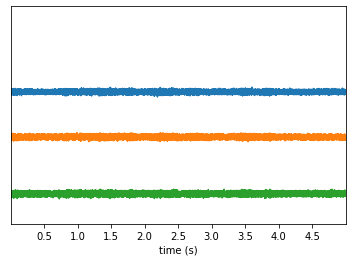

In [6]:
w_ts_ap = sw.plot_timeseries(recording, trange=[0, 5], channel_ids=[1, 2, 3])

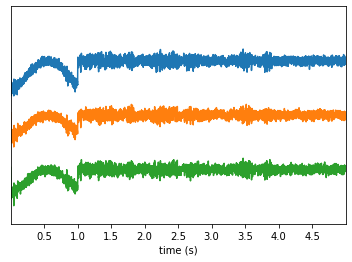

In [7]:
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[0, 5], channel_ids=[1, 2, 3])

## 2) Pre-processing

In [8]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [9]:
# Filtered recordings
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
    
# Stub recording for fast testing; set to False for running processing pipeline on entire data
stub_test = True
nsec_stub = 20
subr_ids = [i + 1 for i in range(20)]
if stub_test:
    recording_processed = se.SubRecordingExtractor(
        parent_recording=recording_processed, 
        channel_ids=subr_ids,
        end_frame=int(nsec_stub*recording_processed.get_sampling_frequency())
    )
    recording_lfp = se.SubRecordingExtractor(recording_lfp, end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency()))
    
print(f"Original signal length: {recording.get_num_frames()}")
print(f"Processed signal length: {recording_processed.get_num_frames()}")

Original signal length: 3633276
Processed signal length: 600000


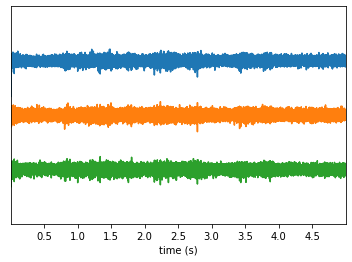

In [10]:
w_ts_ap = sw.plot_timeseries(recording_processed, trange=[0, 5], channel_ids=[1, 2, 3])

## 3) Run spike sorters

In [11]:
ss.installed_sorters()

['herdingspikes', 'klusta', 'spykingcircus']

In [12]:
sorter_list = ['herdingspikes']

# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))

herdingspikes params description:
{'ahpthr': 'Requires magnitude of spike rebound for acceptance',
 'amp_evaluation_time': 'Amplitude evaluation time (ms)',
 'clustering_alpha': 'Scalar for the waveform PC features when clustering.',
 'clustering_bandwidth': 'Meanshift bandwidth, average spatiel extent of spike '
                         'clusters (um)',
 'clustering_bin_seeding': 'Enable clustering bin seeding.',
 'clustering_min_bin_freq': 'Minimum spikes per bin for bin seeding.',
 'clustering_n_jobs': 'Number of cores to use for clustering.',
 'clustering_subset': 'Number of spikes used to build clusters. All by '
                      'default.',
 'decay_filtering': 'Experimental: Set to True at your risk',
 'detect_threshold': 'Detection threshold',
 'filter': 'Enable or disable filter',
 'filter_duplicates': 'Remove spike duplicates (based on spk_evaluation_time)',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'left_cutout_ti

In [13]:
# Choose which recording to use for sorting
rec_to_sort = recording_processed

# spike sort by group
sorting = ss.run_herdingspikes(
    recording=rec_to_sort,
    output_folder=dir_spikeinterface / "si_output",
    pre_scale=False,
    clustering_bin_seeding=False
)

# Generating new position and neighbor files from data file
Warning! The recording is already filtered, but Herding Spikes filter is enabled. You can disable filters by setting 'filter' parameter to False
# Not Masking any Channels
# Sampling rate: 30000
# Localization On
# Number of recorded channels: 20
# Analysing frames: 600000; Seconds: 20.0
# Frames before spike in cutout: 9
# Frames after spike in cutout: 54
# tcuts: 39 84
# tInc: 100000
# Analysing frames from -39 to 100084  (0.0%)
# Analysing frames from 99961 to 200084  (16.7%)
# Analysing frames from 199961 to 300084  (33.3%)
# Analysing frames from 299961 to 400084  (50.0%)
# Analysing frames from 399961 to 500084  (66.7%)
# Analysing frames from 499961 to 600000  (83.3%)
# Detection completed, time taken: 0:00:37.185705
# Time per frame: 0:00:00.061976
# Time per sample: 0:00:00.003099
Loaded 169 spikes.
Fitting dimensionality reduction using all spikes...
...projecting...
...done
Clustering...
Clustering 169 spikes...
num

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    2.0s remaining:    8.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    2.2s finished


Number of estimated units: 71
Saving to /home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_spikeglx/m676p3l11#1/spikeglx/spikeinterface/si_output/HS2_sorted.hdf5


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features
Spike sorters generally output a set of units with corresponding spike trains. The spiketoolkit.postprocessing submodule allows to combine the RecordingExtractor and the sorted SortingExtractor objects to perform further postprocessing.

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html

In [14]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

OrderedDict([('max_spikes_per_unit', 300),
             ('recompute_info', False),
             ('save_property_or_features', True),
             ('memmap', True),
             ('seed', 0),
             ('verbose', False),
             ('joblib_backend', 'loky')])


In [15]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

### Set quality metric list

In [16]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [17]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

### Set extracellular features

In [18]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [19]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

### Postprocess all sorting outputs

In [20]:
# st.validation.compute_quality_metrics?

In [21]:
tmp_folder = dir_spikeinterface / 'tmp' / 'herdingspikes'
tmp_folder.mkdir(parents=True, exist_ok=True)

# set local tmp folder
sorting.set_tmp_folder(tmp_folder)

# compute waveforms
waveforms = st.postprocessing.get_unit_waveforms(
    rec_to_sort, 
    sorting, 
    **postprocessing_params
)

# compute templates
templates = st.postprocessing.get_unit_templates(
    rec_to_sort, sorting, 
    **postprocessing_params
)

# comput EC features
ec = st.postprocessing.compute_unit_template_features(
    rec_to_sort, 
    sorting,
    feature_names=ec_list, 
    as_dataframe=True
)

# compute QCs
qc = st.validation.compute_quality_metrics(
    sorting, 
    recording=rec_to_sort, 
    metric_names=qc_list, 
    as_dataframe=True
)

# export to phy
phy_folder = dir_spikeinterface / 'phy' / 'herdingspikes'
phy_folder.mkdir(parents=True, exist_ok=True)
st.postprocessing.export_to_phy(rec_to_sort, sorting, phy_folder)

Text(0, 0.5, 'Avg spike trace per channel')

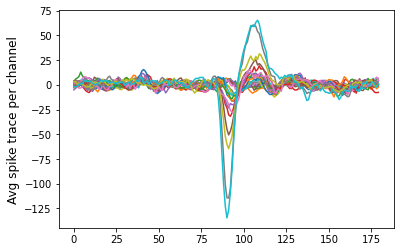

In [22]:
# Visualize spike template waverforms
unit_id = 0

plt.figure()
spk = np.squeeze(templates[unit_id])
plt.plot(spk.T)
plt.ylabel('Avg spike trace per channel', fontsize=12)

# 5) Automatic curation
Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_4_curation.html

In [23]:
# define curators and thresholds
firing_rate_threshold = 0.1
isi_violation_threshold = 0.5
snr_threshold = 5

In [24]:
num_frames = rec_to_sort.get_num_frames()

# firing rate threshold
sorting_curated = st.curation.threshold_firing_rates(
    sorting,
    duration_in_frames=num_frames,
    threshold=firing_rate_threshold, 
    threshold_sign='less'
)

# isi violation threshold
sorting_curated = st.curation.threshold_isi_violations(
    sorting,
    duration_in_frames=num_frames,
    threshold=isi_violation_threshold, 
    threshold_sign='greater'
)

# isi violation threshold
sorting_curated = st.curation.threshold_snrs(
    sorting,
    recording=rec_to_sort,
    threshold=snr_threshold, 
    threshold_sign='less'
)

In [25]:
print(f'Number of sorted units before curation: {len(sorting.get_unit_ids())}')
print(f'Number of sorted units after curation: {len(sorting_curated.get_unit_ids())}')

Number of sorted units before curation: 71
Number of sorted units after curation: 69


# 6) Quick save to NWB using Spikeinterface

In [26]:
output_nwb = 'spikeglx_si_results.nwb'

se.NwbRecordingExtractor.write_recording(
    recording=rec_to_sort,
    save_path=output_nwb,
    overwrite=True
)

se.NwbSortingExtractor.write_sorting(
    sorting=sorting,
    save_path=output_nwb,
    overwrite=False
)

/home/luiz/anaconda3/envs/env_movshon/lib/python3.6/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/media/luiz/storage/Github/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1244: UserWarning: Description for property unit_location not found in property_descriptions. Setting description to 'no description'
  f"Description for property {pr} not found in property_descriptions. "
/home/luiz/anaconda3/envs/env_movshon/lib/python3.6/site-packages/hdmf/build/objectmapper.py:256: DtypeConversionWarning: Spec 'Units/VectorData': Value with data type int64 is being converted to data type uint64 (min specification: uint8).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


In [27]:
# Check NWB file with widgets
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget

io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)